# Assumptions:
* Patients --> Doctors 
  * Each patient `needs` to visit a doctor.
  * Each patient has a `ranked preference list` containing every doctor.
  * Doctors don't have preferences over patients.
  * The `maximum capacity` of each doctor varies. <br>The total capacity exceeds the number of patients.<br><br>

* Doctors --> Hospitals
  * Each doctor `needs` to find a hospital.
  * Each doctor has a `ranked preference list` containing every hospital.
  * Each hospital has a `ranked preference list` containing every doctor.


## Section I, using min cost max flow graph appoarch

## Algorithm introduction:

As shown in the figure below, circles ○ representing patients, and triangles △ representing doctors.<br>
The problem can be modeled into a `bipartite graph`, which means that vertices are separated into two sets and vertices in the same set has no connections between each other. <br><br>
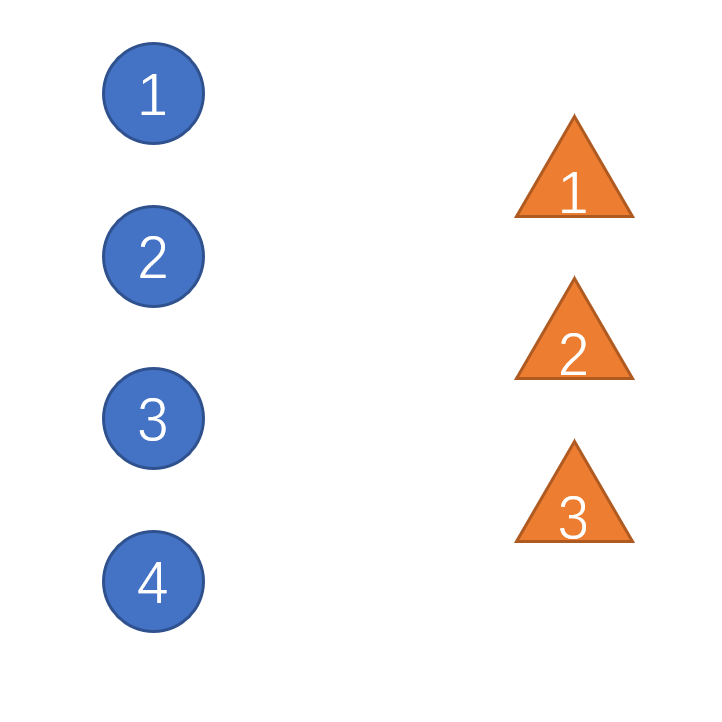

Patient No.1 has a level of preference towards doctor No.1, doctor No.2, and doctor No.3. This can be represented as three different edges pointing from patient No.1 to each doctor, as shown in the figure below. <br><br>
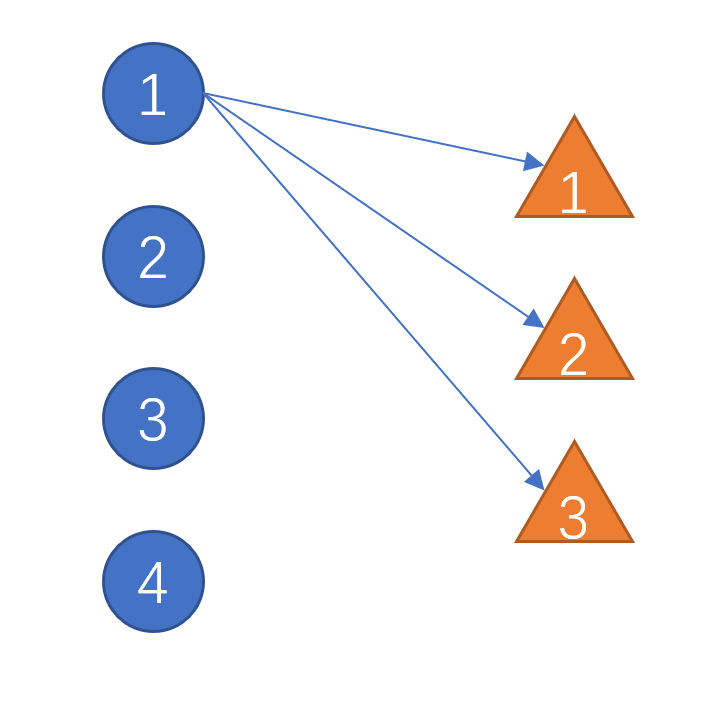

Each patient has a level of preference towards each doctor. Now the problem can be represented as the figure below. <br><br>
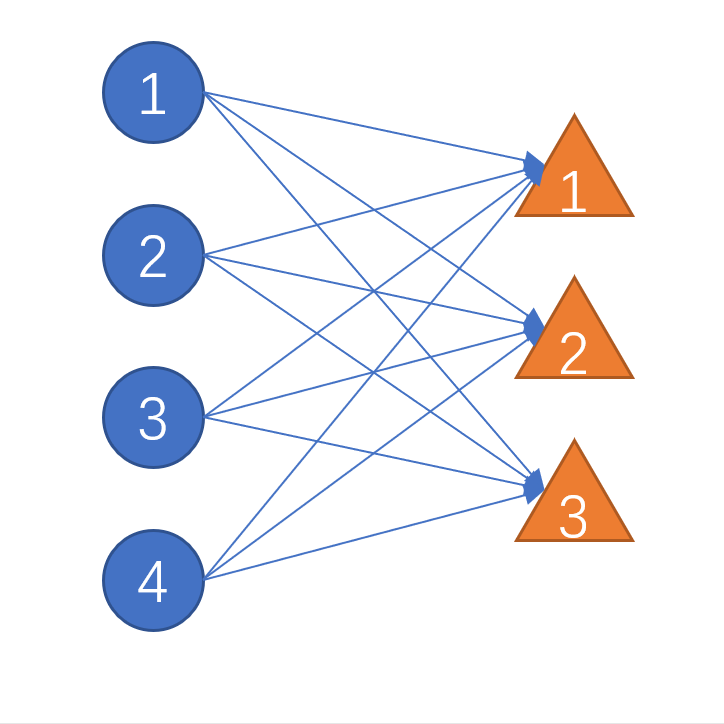

### What we need to find out is that, what is the `most satisfying` arrangement when ensuring `every patient can meet a doctor`.<br>
* We can translate `most satisfying` into `least cost`, where the cost is the preference ranking. If a patient rank a doctor as their favorite, the rank value is the smallest, which can be used as a cost. We set the cost of each edge as the preference ranking.<br>
* Also, we can translate `every patient can meet a doctor` into `maximize the matching number`, which can be translated into `maximize flow  under certain restrictions`. Since that each person is ONE person and can only take 1 capacity of a doctor's office, we set the flow capacity of each edge as 1.<br>
* For example, if patient No.1 likes doctor No.1 the most, doctor No.2 the second, and doctor No.3 the least, the costs and flow capacities of patient No.1's edges are as below. (Edge: flow_capacity (cost) )<br><br>

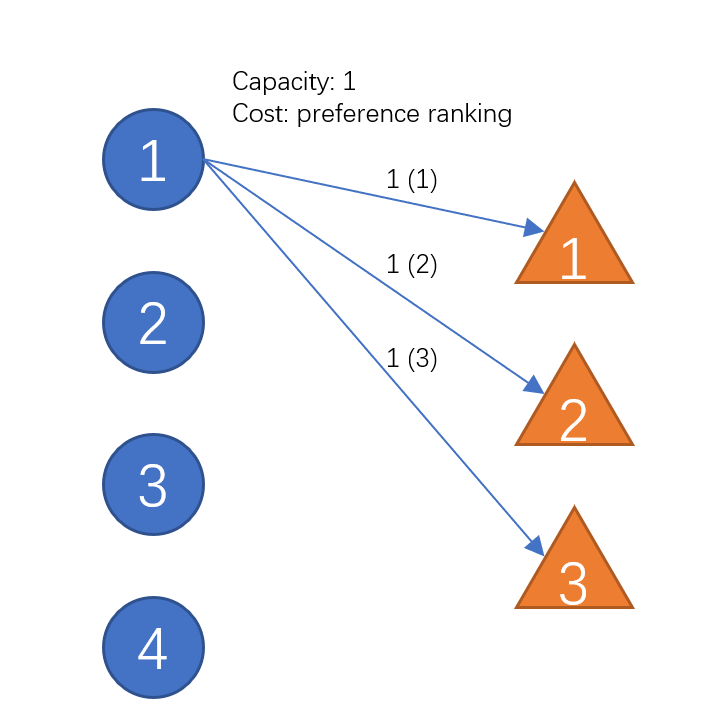

* Add a starting point `S` and connect it with every patient point. We set the flow capacities of these edges as 1. This way, a patient can maximumly choose one doctor. <br>
* Add a ending point `E` and connect it with every doctor point. We set the flow capacities of these edges as each doctor's capcities. This way, a doctor can maximumly take in their capacity amount of patients.<br>
* Set the costs of all starting and ending edges as 0. This way, only patients' preferences towards doctors can contribute to costs.<br><br>
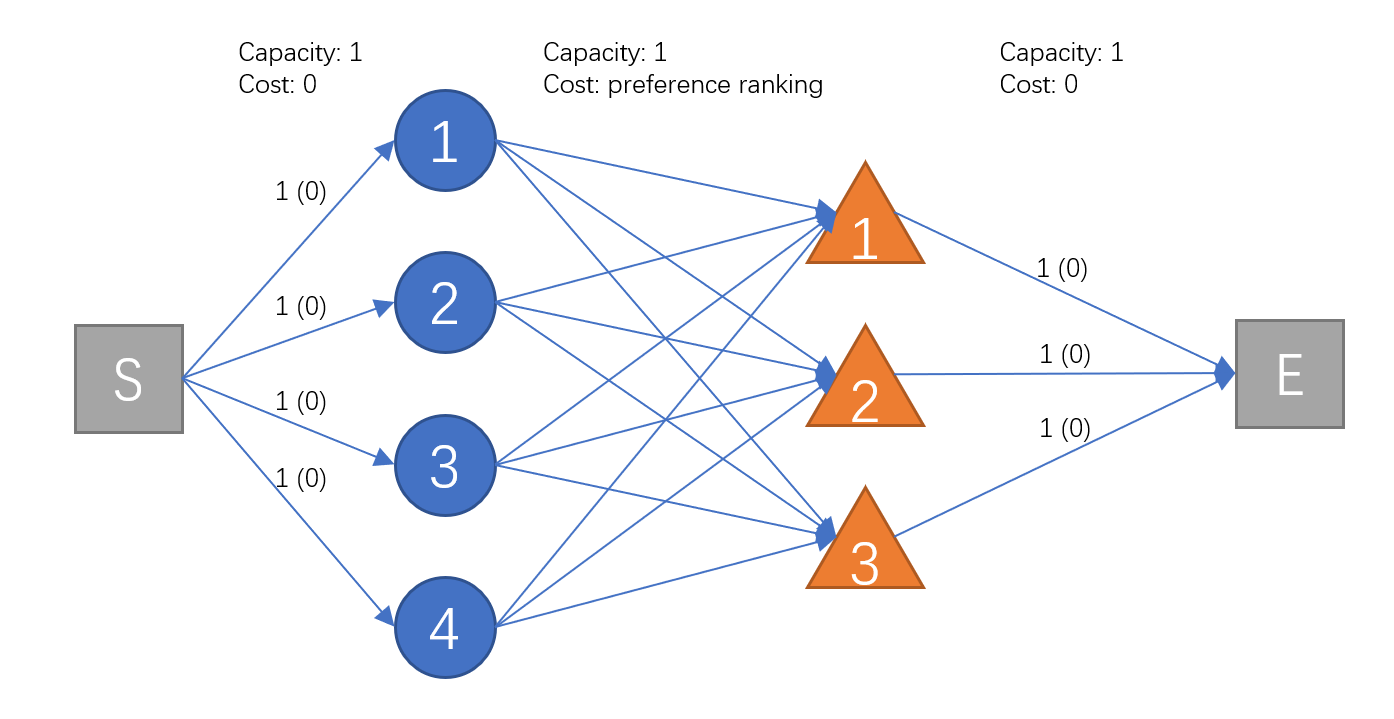

The problem is now a classic `minimum cost maximum flow` problem.
The algorithm follows the below flowchart. It searches for the least-cost path in all the paths that still have left some flow capacities, and fills the path with maximum flow. The algorithms repeats itself until there is no more available path.<br><br>
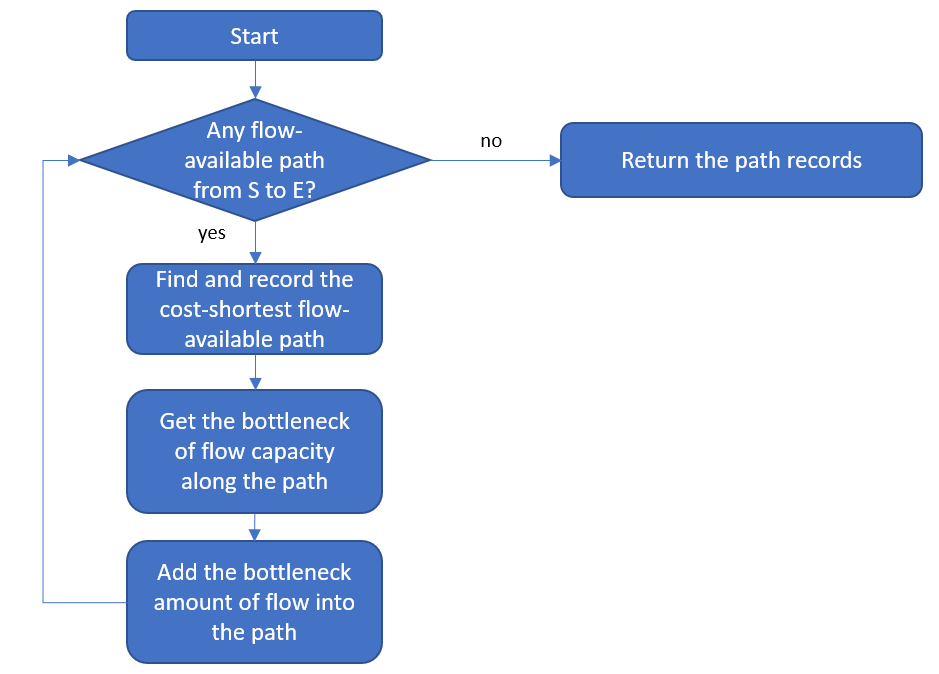

## Code implementation:

### Input:
* K: an integer, represents `the number of patients`.
* N: an integer, represents `the number of doctors`.
* C: a list of integers separated by spaces, represents `the capacity of each doctor`.
* Rank orders: K lines of list of integers separated by spaces, represents `each patient's ranked preferences` over doctors.

### Input example:

In [1]:
def input_patient_preference_list(N):
    rank=[[]]*N
    #rank: list of lists, every list's order represent a patient's prefered doctor's number, listed from most like to least like.
    # e.g. "4 2 3 1" represent the patient likes doctor 4 more than doctor 2, and so on.
    for i in range(N):
        input_string=input("Rank Order of Patient No.%d:" %(i+1)) #input seperated by space " "
        rank[i]=input_string.split()
        rank[i]=[int(ele) for ele in rank[i]]
    return rank


N=int(input("Number of Patients:"))
K=int(input("Number of Doctors:"))
C=[]                                            #same/different capacity for each doctor
input_string=input("Capacity of Each Doctor:")  #input seperated by space " "
C=input_string.split()
C=[int(ele) for ele in C]  #turn into integers
rank=input_patient_preference_list(N) #patients' preferences
points=[]                       #dots in the graph
for i in range(N+K+2):
    points.append(i)

Number of Patients:4
Number of Doctors:3
Capacity of Each Doctor:1 2 2
Rank Order of Patient No.1:1 2 3
Rank Order of Patient No.2:2 1 3
Rank Order of Patient No.3:1 2 3
Rank Order of Patient No.4:2 1 3


### This means:
* There are 4 patients and 3 doctors.
* Doctor No.1 has a capacity of 1. Doctor No.2 has a capacity of 2. Doctor No.3 has a capacity of 2.
* Patient No.1 prefers Doctor No.1 most, then Doctor No.2, and Doctor No.3 least.
* Patient No.2 prefers Doctor No.2 most, then Doctor No.1, and Doctor No.3 least.
* And so on...

### Output
* A simple chart containing 2 columns, `Doctor` and `Patient(s)`.
* Each row represents a patient-doctor arrangement.

### Output example:

In [2]:
class Graph:
    def __init__(self,points):
        self.costTab={}        #table of costs
        self.capTab={}         #table of capacities
        self.resCap={}         #residual/left capacities
        self.backPath={}       #backward arcs
        self.len=len(points)
        self.INF=1e9
        for i in points:
            self.costTab.update({i:{}})
            self.capTab.update({i:{}})
            self.resCap.update({i:{}})

    def addEdge(self,s,t,cap,cost):
        self.costTab[s].update({t:cost})
        self.capTab[s].update({t:cap})
        self.resCap[s].update({t:cap})

    def costFlow(self,s,t):
        path=self.SPFA(s,t)
        while path:
            #print(" \n\nthe shortest path:",path)
            minFlow=self.findMinFlow(path,s,t)
            #print("the bottleneck: ",minFlow)
            self.changeFlow(minFlow,path,s,t)
            path=self.SPFA(s,t)
        return self.backPath

    def SPFA(self,s,t):
        que=[]          #spfa's que
        path=[0]*self.len          #record the shortest path
        dist=[self.INF]*self.len              #spfa's dist
        visited=[False]*self.len         #whether the point is in spfa's que

        dist[s]=0
        que.append(s);visited[s]=True        #the source in que

        while que:
            nowPoint=que[0]
            que.pop(0)
            visited[nowPoint]=False  #take out the first element in que
            for linkPoint,leftCapacity in self.resCap[nowPoint].items():  #its connected points  /  edges
                if (leftCapacity!=0)&(dist[linkPoint]>dist[nowPoint]+self.costTab[nowPoint][linkPoint]):
                    dist[linkPoint]=dist[nowPoint]+self.costTab[nowPoint][linkPoint]  #refresh the shorted path
                    path[linkPoint]=nowPoint
                    if not visited[linkPoint]:   #add in que
                        que.append(linkPoint)
                        visited[linkPoint]=True
        if dist[t]!=self.INF:
            return path
        else:
            return False

    def findMinFlow(self,path,s,t):
        pathNow=t
        mm=self.INF
        while pathNow!=s:
            pathPre=path[pathNow]
            if self.resCap[pathPre][pathNow]<mm:
                mm=self.resCap[pathPre][pathNow]
            pathNow=pathPre
        if mm!=self.INF:
            return mm
        else:
            return -1

    def changeFlow(self,minFlow,path,s,t):
        pathNow = t
        #print("backwards change flow path:",pathNow,end="")
        while pathNow != s:
            pathPre = path[pathNow]
            #print("->",pathPre,end="")
            self.resCap[pathPre][pathNow]-=minFlow
            if pathNow not in self.backPath:
                self.backPath[pathNow] = {}
            if pathPre not in self.backPath[pathNow]:
                self.backPath[pathNow][pathPre] = 0
            self.backPath[pathNow][pathPre]+=minFlow
            pathNow = pathPre
            
G=Graph(points)

for i in range(N):
    G.addEdge(0,i+1,1,0)                     #from source to patient: capacity 1, cost 0
for i in range(N):
    for j in range(K):
        G.addEdge(i+1,j+N+1,1,rank[i][j])    #from patient to doctor: capacity 1, cost (preferences)
for i in range(K):
    G.addEdge(i+N+1,N+K+1,C[i],0)            #from doctor to terminal: capacity (doc_cap), cost 0

s=0;t=N+K+1
outputTab=G.costFlow(s,t)

title="\nAssignments:\n    Doctor"+" "*8+"Patient(s)    "
print(title)
print("-"*(len(title)-len("\nAssignments:\n)")),end="")
for doctor,linkage in outputTab.items():
    if (doctor>N)&(doctor<N+K+1):   #if this node is a doctor node
        print("\n     No.%d         "%(doctor-N),end="")
        #print("\nDoctor No.%d"%(p-N),"will take in Patient ",end="")
        for patient,choice in linkage.items():
            print(" No.%d "%(patient),end="")
            #print("No. %d  "%(patient),end="")


Assignments:
    Doctor        Patient(s)    
-------------------------------
     No.1          No.1 
     No.2          No.2  No.4 
     No.3          No.3 

### This means the most satisfying assignment is: 
* Doctor No.1 takes in Patient No.1, 
* Doctor No.2 takes in Patient No.2 and No.4, 
* Doctor No.3 takes in Patient No.3.

<br>

## Section II, using the NRMP appoarch for the additonal question

### First I will briefly explain how the NRMP algoritm works. 
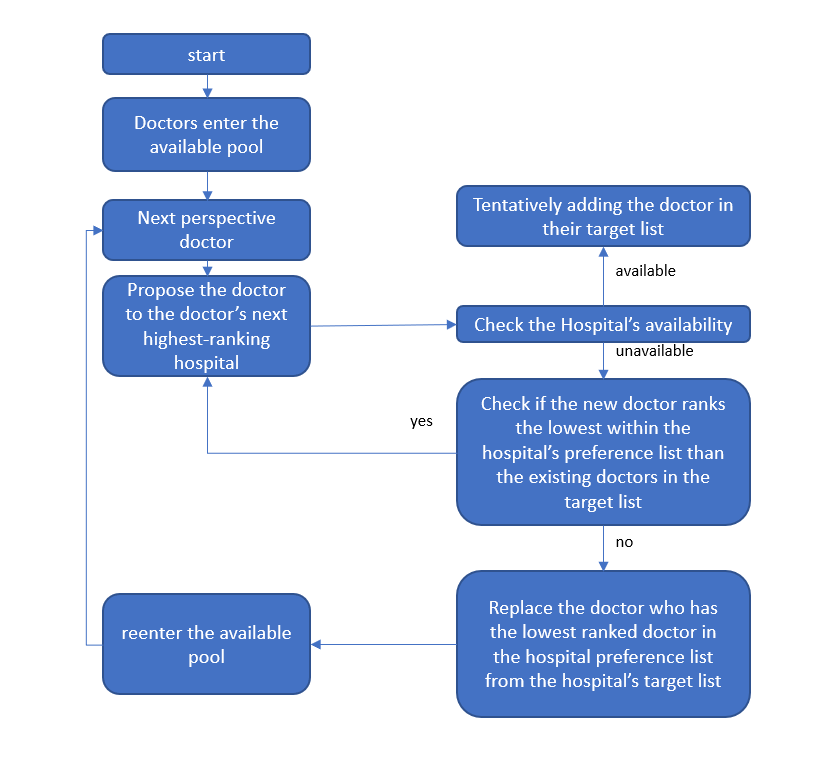

1, The doctor and the hospital will first implement it's preference list <br>
2, Doctors will enter a avaible pool<br>
3, The system will propose the doctor to it's next highest ranking hospital <br>
4, The hospital will check if the doctor runs the lowest preference in it's target list. <br>
5, If the doctor does ranked as the lowest, the system will try to propose the doctor to his/her next highest ranking hospital. <br>
6, if the doctor ranked higher in the hospital's target list, the system will remove the lowest ranking doctor in the hospital's target list to make room for the current doctor. The removed doctor will reenter the available pool. <br>
7, The system will keep running until all doctors leave the avaible pool. <br> 

In [5]:

'''
Assuming that:
1, every doctor ranks every hospital in their preference list
2, every hospital ranks every perspective doctors in their preference list
3, input of the doctors perference is in the format of (doctors*hospitals)
4, input of the hospital perference is in the format of (hospitals*doctors)
5, the output is in the format of #hospitals lists of list containing the admission result 

'''
import math
import numpy as np


######################################################################################################
#                                       Algorithm design                                             #
######################################################################################################   

'''
This is a method that checks if there is a higher ranking doctor in the hospital's tentative acceptence list


input: 
    Doctor_Id: the doctor id of the new coming doctor 
    Hospital_Id: the new coming doctor's choise of hospital

output:
    status: 
        0: there is an replaced doctor 
        -1: there is no replaced doctor 
        -2: the exisitng doctors in the hospital target list all rank higher than the new coming doctor 
'''
# check if there's a higher ranked docter in the hospital target list 
# Doctor Id and Hospital Id must start from 1 
def higher_ranker_check(Doctor_Id, Hospital_Id, Hospital_target_list):
    # if the list is empty or have avalible space add the doctor in the target list 
    if len(Hospital_target_list[Hospital_Id -  1]) == 0 or len(Hospital_target_list[Hospital_Id -1 ]) < Hospital_cap:
        Hospital_target_list[Hospital_Id -1 ].append(Doctor_Id) 
        Doctor_is_occupied_list[Doctor_Id-1] = True # set the docters status as occupied
        return -1 # -1 means there's no replaced doctor in record 
    else:
        # if the hospital list is full
        replaceble_doctor_list = []
        replaceble_doctor_Id = None
        # finding the replaceble doctor's ID 
        for doctor_ID_in_hospital_list in Hospital_target_list[Hospital_Id -1 ]:
            # if an exisiting doctor in the list ranks shorter than the new coming doctor, the existing doctor will be move to the replaceble list
            if Hospital_Rank[Hospital_Id -1 ].index(doctor_ID_in_hospital_list) > Hospital_Rank[Hospital_Id-1].index(Doctor_Id):
                #replaceble_doctor_Id = doctor_ID_in_hospital_list
                # if the replacable_doctor_list is empty and the replaceble doctor's ID
                if len(replaceble_doctor_list) == 0:
                    replaceble_doctor_Id = doctor_ID_in_hospital_list
                    replaceble_doctor_list.append(replaceble_doctor_Id)
                else: 
                    # find the shortest ranking replaceble doctor
                    if Hospital_Rank[Hospital_Id -1 ].index(doctor_ID_in_hospital_list) > Hospital_Rank[Hospital_Id -1 ].index(replaceble_doctor_Id):
                        replaceble_doctor_Id = doctor_ID_in_hospital_list
                        replaceble_doctor_list[0] = replaceble_doctor_Id
        # if there is a replaceble doctor in the hospital's target list
        if replaceble_doctor_Id is not None:
            Hospital_target_list[Hospital_Id -1 ].remove(replaceble_doctor_Id) # remove the replaced docter ID from the target list 
            Doctor_is_occupied_list[replaceble_doctor_Id-1] =False # set the replaced doctor status as available
            Hospital_target_list[Hospital_Id -1].append(Doctor_Id) # add the new doctor's ID in the list
            Doctor_is_occupied_list[Doctor_Id-1] = True # set the docters status as occupied
            return 0 # 0 indicates there are replaced doctor in the record
        else: 
            return -2 # -2 indicates that the exisitng doctors in the hospital target list all rank higher than the new coming doctor



'''
This is the main running function that runs the algorithm


input: 
    1, Doctor_is_occupied_list: a list of the occupation status for each doctor
        Ture: this doctor has been reserved by certain hospital
        False: this doctor has no hospital reserved him/her yet
    2, num_doctor: number of perspective doctor 
    3, Doctor_Rank: a list for each doctor's hospital perfrence ranking
    4, Hospital_target_list: Hospital's tentative acceptance list
output:
    1, Hopital_final_list: Hospital's final acceptance list
'''

def run(Doctor_is_occupied_list, num_doctor, Doctor_Rank, Hospital_target_list):
    while all(Doctor_is_occupied_list) == False:
        for i in range(num_doctor):
            if Doctor_is_occupied_list[i] == False:
                Doctor_Id = i+1
                Doctor_Hospital_choice = Doctor_Rank[i][0]
                status = higher_ranker_check(Doctor_Id, Doctor_Hospital_choice, Hospital_target_list)
                del Doctor_Rank[i][0] # remove it's perfernece once submitted
                # if the submission is rejected by the hosipital and the doctor still has a perfernece, try the next perference hoispital
                while status == -2 and len(Doctor_Rank[i]) !=0: 
                    Doctor_Hospital_choice = Doctor_Rank[i][0]
                    status = higher_ranker_check(Doctor_Id, Doctor_Hospital_choice, Hospital_target_list)
                    del Doctor_Rank[i][0] #remove it's perfernece once submitted
                if status == -2 and len(Doctor_Rank[i])==0:
                    Doctor_is_occupied_list[i] = None
                
                
    for i in range(len(Hospital_target_list)):
        print('Hospital #: ' + str(i+1) + ' accepted doctor list is: ')
        print(Hospital_target_list[i])
    return Hospital_target_list

Now lets run this algorithm

In [2]:
######################################################################################################
#                                       Algorithm example run                                        #
######################################################################################################   
# define constants 
'''
Test test example
'''
num_doctor = 10
num_Hospital = 4
Hospital_cap = math.ceil(num_doctor/num_Hospital)
Doctor_Rank = [[1,2,3,4],[3,2,1,4],[4,1,3,2],[3,2,4,1],[3,1,4,2],[3,1,2,4],[4,3,2,1],[3,2,1,4],[2,1,3,4],[1,3,4,2]]
Hospital_Rank = [[1,2,3,4,5,6,7,8,9,10],[2,1,4,3,5,10,9,6,8,7],[6,2,1,3,5,4,7,10,9,8],[5,4,3,2,1,10,9,8,7,6]]
Doctor_is_occupied_list = [False]*num_doctor

Hospital_target_list = [[] for _ in range(num_Hospital)] 


# running the algrothim
Hospital_confirmed_list = run(Doctor_is_occupied_list, num_doctor, Doctor_Rank, Hospital_target_list)
print(Hospital_confirmed_list)

IndentationError: ignored

The Hospital_confirmed_list was made by appending individual hospital's comfirmed list. The first index - 1  is the Hospital ID, for example Hospital 1's comfirmed list is Hospital_confirmed_list[0]. The entries of each hospital's comfirmed list is the doctors ID, for example Hospital 1 has an entry of [1,2,3], that means Hospital 1 chooses doctor 1, doctor 2, and doctor 3. 